[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/axr/blob/master/axr/01_bandits.ipynb)

# Exploración vs Explotación

La principal diferencia entre el axr y el resto de métodos de aprendizaje es que durante el entrenamiento un agente aprende a través de la *evaluación* de las acciones tomadas en vez de ser *instruido* diciéndole exactamente qué acciones son las correctas (aprendizaje supervisado). Es por este motivo que necesitamos de una exploración activa, de forma que a través de la prueba y el error nuestro agente descubra las mejores acciones para poder explotarlas en el futuro.


## *Whac-A-Mole*

En este post vamos a estudiar el aspecto evaluador en su configuración más básica, sin considerar aprendizaje para actuar en más de una situación. Esto nos permitirá introducir los conceptos básicos de exploración vs explotación que usaremos y extendermos más adelante para resolver problemas más complejos. Para ello usaremos de ejemplo el juego [*Whac-A-Mole*](https://es.wikipedia.org/wiki/Whac-A-Mole). En la versión original arcade de este juego, el jugador tenía que golpear con un mazo a topos pequeños que iban apareciendo de manera aleatoria. Cuánto más rápido golpease, más puntos obtenía. Nosotros usaremos una versión un poco modificada, en la que el jugador tendrá que clicar los topos en vez de golpearlos (los cuales estarán siempre en pantalla en vez de ir apareciendo y desapareciendo). Además, cada uno de los topos dará una cantidad de puntos diferentes, un valor numérico obtenido de en una distribución de probabilidad estacionaria. Así pues, el problema se base en tomar una decisión (acción) de entre varias: ¿qué topo golpear para obtener la máxima puntuación?

![](https://media1.giphy.com/media/ebITvSXYKNvRm/giphy.gif)

Empezamos definiendo el *valor* de una acción como la **recompensa esperada** tras seleccionar dicha acción.

$$
    q_*(a) = \mathbb{E}[R_t | A_t = a]
$$

donde $q_*(a)$ es el valor de la acción $a$, que corresponde a la acción $A_t$ tomada en el instante $t$ y $R_t$ es su recompensa. Conociendo este valor, el problema se resuelve escogiendo en cada momento aquella acción con mayor valor. El problema es que, a priori, no conocemos este valor, pero podemos aproximarlo. Para ello, definimos $Q_t(a)$ como el valor estimado de la acción $a$ en el instante $t$, cuyo valor queremos que sea tan cercano a $q_*(a)$ como sea posible.

Si en cada instante $t$ llevamos a cabo la acción con un mayor valor estimado, estaremos **explotando** nuestro conocimiento y es el método adecuado si queremos maximizar la recompensa final. Si elegimos otras acciones con un menor valor estimado, estermos **explorando** con el objetivo de encontrar nuevos estados desconocidos con mayor recompensa. El correcto balance de ambas estrategias es crucial para encontrar soluciones óptimas, pero cualquier método necesita de algún tipo de conocimiento previo sobre el entorno y su comportamiento. Generalmente se prefiere una mayor exploración al principio, cuando el conocimiento del entorno es limitado, que va disminuyendo en favor de una mayor explotación a medida que este conocimiento mejora.

## Métodos de acción-valor

Los métodos de **acción-valor** consisten en la estimación de los valores de acciones para poder usarlos a la hora de tomar decisiones. Una manera simple de estimar el valor de una acción consiste en promediar la recompensa recibida en un conjunto de episodios.


$$
    Q_t(a) = \frac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{1}_{A_i=a}}{\sum_{i=1}^{t-1}\mathbb{1}_{A_i=a}}
$$

donde $\mathbb{1}_{x}$ es $1$ si $x$ es verdad y $0$ en caso contrario. En el caso que el denominador sea 0, $Q_t(a)$ se iguala a un valor por defecto (por ejemplo 0) mientras que si el denominador crece hacia infinito, $Q_t(a)$ converge a $q_*(a)$. La forma más simple de escoger una acción será elegir aquella con el valor estimado más grande.


$$
    A_t = \underset{a}{\arg\max} \, Q_t(a)
$$

Una alternativa para favorecer la exploración consiste en tomar acciones aleatorias de vez en cuando, con una probabilidad $\epsilon$. Este tipo de métodos se conocen como $\epsilon-greedy$. En el límite, todas las acciones serán esogidas asegurando que $Q_t(a)$ converge a $q_*(a)$. Vamos a comparar ambos métodos en el caso de tener 5 topos en nuestro juego. Para cada topo, el valor óptimo $q_*(a)$ y su recompensa será un valor aleatorio elegido de una distribución normal con media $q_*(a)$ y desviación estándar 1.

NOMBRE: LRCQ                                                    CARRERA:CICO

REPOSITORIO: https://github.com/luis1308-5687/Lab-7-8

In [10]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np

class NChainEnv(gym.Env):
    """n-Chain environment adapted to Gym latest API"""

    def __init__(self, n=5, slip=0.2, small=2, large=10):
        super().__init__()
        self.n = n
        self.slip = slip  # probability of 'slipping' an action
        self.small = small  # reward for 'backwards' action
        self.large = large  # reward at end of chain for 'forwards' action
        self.state = 0  # Start at beginning of the chain
        self.action_space = spaces.Discrete(2)  
        self.observation_space = spaces.Discrete(self.n)
        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
    
        if self.np_random.random() < self.slip:
            action = 1 - action  

        if action == 1:  
            reward = self.small
            self.state = 0
        elif self.state < self.n - 1:  
            reward = 0
            self.state += 1
        else:  
            reward = self.large

        terminated = False  
        truncated = False  
        info = {}

        return self.state, reward, terminated, truncated, info

    def reset(self):
        self.state = 0
        return self.state



if __name__ == "__main__":
    env = NChainEnv(slip=0.1)
    state = env.reset()
    print(f"Estado inicial: {state}")

    for _ in range(10):
        prev_state = state  
        action = env.action_space.sample()  
        state, reward, terminated, truncated, info = env.step(action)
        print(f"Estado anterior: {prev_state}, Acción: {action}, Nuevo estado: {state}, Recompensa: {reward}")




Estado inicial: 0
Estado anterior: 0, Acción: 1, Nuevo estado: 0, Recompensa: 2
Estado anterior: 0, Acción: 0, Nuevo estado: 1, Recompensa: 0
Estado anterior: 1, Acción: 1, Nuevo estado: 0, Recompensa: 2
Estado anterior: 0, Acción: 0, Nuevo estado: 1, Recompensa: 0
Estado anterior: 1, Acción: 0, Nuevo estado: 2, Recompensa: 0
Estado anterior: 2, Acción: 1, Nuevo estado: 0, Recompensa: 2
Estado anterior: 0, Acción: 1, Nuevo estado: 0, Recompensa: 2
Estado anterior: 0, Acción: 1, Nuevo estado: 0, Recompensa: 2
Estado anterior: 0, Acción: 0, Nuevo estado: 1, Recompensa: 0
Estado anterior: 1, Acción: 0, Nuevo estado: 0, Recompensa: 2


ESTADOS GENERADOS:
Estado inicial: 0
Estado anterior: 0, Acción: 1, Nuevo estado: 0, Recompensa: 2
Estado anterior: 0, Acción: 0, Nuevo estado: 1, Recompensa: 0
Estado anterior: 1, Acción: 1, Nuevo estado: 0, Recompensa: 2
Estado anterior: 0, Acción: 1, Nuevo estado: 0, Recompensa: 2
Estado anterior: 0, Acción: 0, Nuevo estado: 1, Recompensa: 0
Estado anterior: 1, Acción: 0, Nuevo estado: 2, Recompensa: 0
Estado anterior: 2, Acción: 0, Nuevo estado: 3, Recompensa: 0
Estado anterior: 3, Acción: 0, Nuevo estado: 4, Recompensa: 0
Estado anterior: 4, Acción: 0, Nuevo estado: 4, Recompensa: 10
Estado anterior: 4, Acción: 0, Nuevo estado: 4, Recompensa: 10

#JUEGO NCHAIN-VO

PRIMER METODO: Implementación incremental

<>:84: SyntaxWarning: invalid escape sequence '\e'
<>:84: SyntaxWarning: invalid escape sequence '\e'
C:\Users\luisc\AppData\Local\Temp\ipykernel_61320\7182633.py:84: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(recompensas_medias[i], label=f'$\epsilon$={epsilon}')


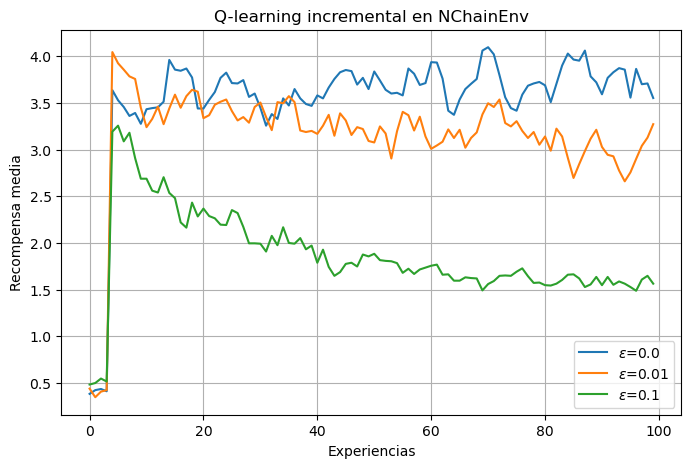

In [12]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt

# Definición del entorno NChainEnv
class NChainEnv(gym.Env):
    def __init__(self, n=5, slip=0.2, small=2, large=10):
        super().__init__()
        self.n = n
        self.slip = slip
        self.small = small
        self.large = large
        self.state = 0
        self.action_space = spaces.Discrete(2)  # 0: adelante, 1: atrás
        self.observation_space = spaces.Discrete(self.n)
        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if self.np_random.random() < self.slip:
            action = 1 - action  # acción invertida por slip

        if action == 1:  # backward: ir al inicio con pequeña recompensa
            reward = self.small
            self.state = 0
        elif self.state < self.n - 1:  # forward: avanzar sin recompensa
            reward = 0
            self.state += 1
        else:  # en el final, forward da recompensa grande
            reward = self.large

        done = False
        return self.state, reward, done, {}

    def reset(self):
        self.state = 0
        return self.state


partidas = 500
turnos = 100
alpha = 0.5
epsilons = [0., 0.01, 0.1]

recompensas_medias = np.zeros((len(epsilons), turnos))
acciones_optimas = np.zeros((len(epsilons), turnos))

for ej in range(partidas):
    for i, epsilon in enumerate(epsilons):
        env = NChainEnv()
        state = env.reset()
        Q = np.zeros(env.action_space.n)  # Q para 2 acciones: 0 y 1
        mejor_accion = 0  # acción 0 (forward) es óptima

        for exp in range(turnos):
            # epsilon-greedy para seleccionar acción
            if np.random.uniform() < epsilon:
                a = env.action_space.sample()
            else:
                a = np.argmax(Q)

            next_state, recompensa, done, _ = env.step(a)
            # actualizar Q incremental
            Q[a] += alpha * (recompensa - Q[a])

            recompensas_medias[i][exp] += recompensa
            acciones_optimas[i][exp] += (a == mejor_accion)

            state = next_state

# promediar resultados
recompensas_medias /= partidas
acciones_optimas /= partidas

# graficar recompensa media
plt.figure(figsize=(8,5))
for i, epsilon in enumerate(epsilons):
    plt.plot(recompensas_medias[i], label=f'$\epsilon$={epsilon}')
plt.legend()
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.title('Q-learning incremental en NChainEnv')
plt.grid(True)
plt.show()



SEGUNDO METODO: Valores iniciales optimistas

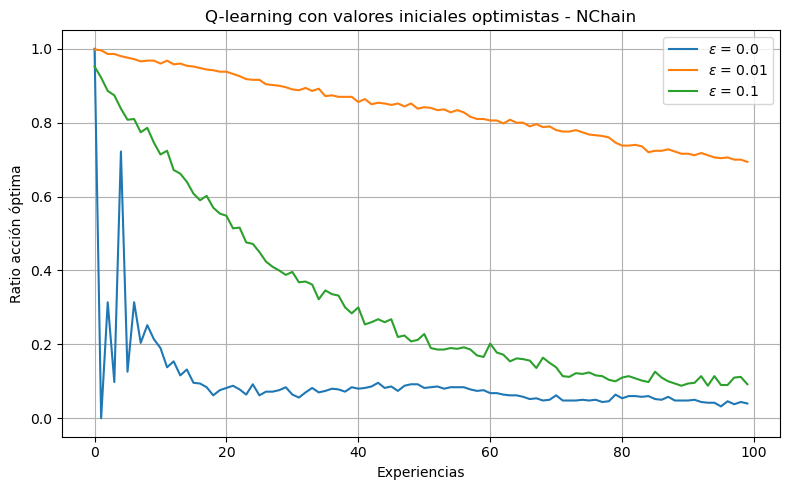

In [13]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt

# Definición del entorno NChain personalizado
class NChainEnv(gym.Env):
    def __init__(self, n=5, slip=0.2, small=2, large=10):
        super().__init__()
        self.n = n
        self.slip = slip
        self.small = small
        self.large = large
        self.state = 0
        self.action_space = spaces.Discrete(2)  # 0: adelante, 1: atrás
        self.observation_space = spaces.Discrete(self.n)
        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if self.np_random.random() < self.slip:
            action = 1 - action  # acción invertida por deslizamiento

        if action == 1:  # ir hacia atrás
            reward = self.small
            self.state = 0
        elif self.state < self.n - 1:  # avanzar sin recompensa
            reward = 0
            self.state += 1
        else:  # último estado, gran recompensa
            reward = self.large

        done = False
        return self.state, reward, done, {}

    def reset(self):
        self.state = 0
        return self.state


# Q-learning con valores iniciales optimistas
partidas = 500
turnos = 100
alpha = 0.5
epsilons = [0., 0.01, 0.1]  # Greedy puro y epsilon-greedy

recompensas_medias = np.zeros((len(epsilons), turnos))
acciones_optimas = np.zeros((len(epsilons), turnos))

for ej in range(partidas):
    for i, epsilon in enumerate(epsilons):
        env = NChainEnv()
        state = env.reset()
        Q = np.zeros(env.action_space.n)
        mejor_accion = 0  # en NChain, acción 0 (avanzar) es la óptima

        # Valores iniciales optimistas para greedy puro
        if epsilon == 0.0:
            Q[:] = 5.0

        for exp in range(turnos):
            # Política epsilon-greedy
            if np.random.uniform() < epsilon:
                a = env.action_space.sample()  # Explora
            else:
                a = np.argmax(Q)               # Explota

            next_state, recompensa, done, _ = env.step(a)
            Q[a] += alpha * (recompensa - Q[a])  # actualización Q
            recompensas_medias[i][exp] += recompensa
            acciones_optimas[i][exp] += (a == mejor_accion)
            state = next_state

# Promediar resultados
recompensas_medias /= partidas
acciones_optimas /= partidas

# Gráfica: porcentaje de acciones óptimas
plt.figure(figsize=(8, 5))
for i, epsilon in enumerate(epsilons):
    plt.plot(acciones_optimas[i], label=f'$\\epsilon$ = {epsilon}')
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.title('Q-learning con valores iniciales optimistas - NChain')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




TERCER METODO: Selección de acciones con intervalo de confianza

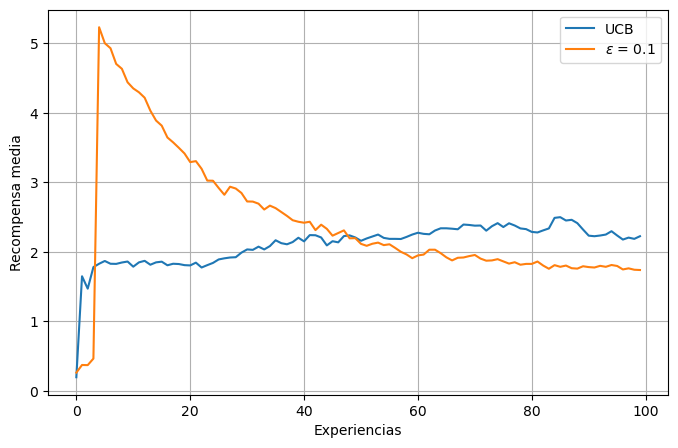

In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from gym.utils import seeding

class NChainEnv(gym.Env):
    def __init__(self, n=5, slip=0.2, small=2, large=10):
        self.n = n
        self.slip = slip
        self.small = small
        self.large = large
        self.state = 0
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Discrete(self.n)
        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if self.np_random.uniform() < self.slip:
            action = 1 - action

        if action == 1:
            reward = self.small
            self.state = 0
        elif self.state < self.n - 1:
            reward = 0
            self.state += 1
        else:
            reward = self.large

        done = False
        return self.state, reward, done, {}

    def reset(self):
        self.state = 0
        return self.state

# Parámetros
partidas = 1000
turnos = 100
alpha = 0.5
c = 1
epsilons = [0.1, 0.1]  # UCB y epsilon-greedy

recompensas_medias = np.zeros((len(epsilons), turnos))

env = NChainEnv(slip=0.1)
acciones_posibles = list(range(env.action_space.n))

for partida in range(partidas):
    for i, epsilon in enumerate(epsilons):
        Q = {a: 0.0 for a in acciones_posibles}
        N = {a: 1 for a in acciones_posibles}  # evitar div/0

        state = env.reset()

        for t in range(turnos):
            if i == 0:  # UCB
                max_ucb = -float('inf')
                a = None
                for action in acciones_posibles:
                    ucb_val = Q[action] + c * math.sqrt(math.log(t + 1) / N[action])
                    if ucb_val > max_ucb:
                        max_ucb = ucb_val
                        a = action
            else:
                if np.random.rand() < epsilon:
                    a = np.random.choice(acciones_posibles)
                else:
                    a = max(Q, key=Q.get)

            new_state, recompensa, done, _ = env.step(a)
            Q[a] += alpha * (recompensa - Q[a])
            N[a] += 1

            recompensas_medias[i][t] += recompensa

            state = new_state
            if done:
                break

recompensas_medias /= partidas

plt.figure(figsize=(8,5))
for i, epsilon in enumerate(epsilons):
    label = "UCB" if i == 0 else f"$\\epsilon$ = {epsilon}"
    plt.plot(recompensas_medias[i], label=label)
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.show()



CUARTO METODO: Algoritmos de Gradiente

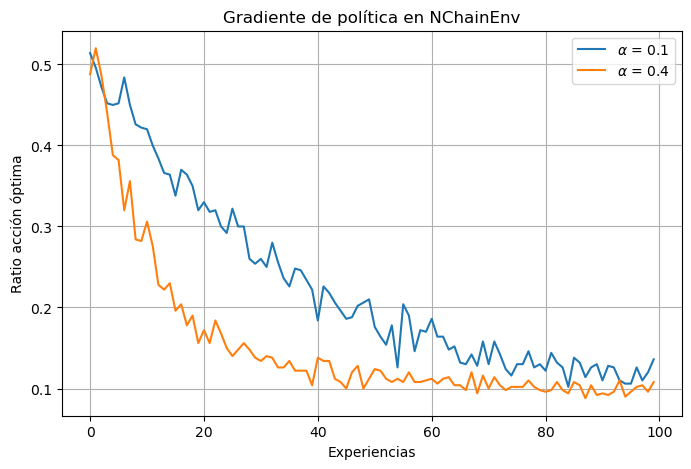

In [15]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt

# Definición corregida de NChainEnv:
class NChainEnv(gym.Env):
    def __init__(self, n=5, slip=0.2, small=2, large=10):
        self.n = n
        self.slip = slip
        self.small = small
        self.large = large
        self.state = 0
        self.action_space = spaces.Discrete(2)  # 0: forward, 1: backward
        self.observation_space = spaces.Discrete(self.n)
        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if self.np_random.uniform() < self.slip:
            action = 1 - action  # slip reverses action

        if action == 1:  # backward action
            reward = self.small
            self.state = 0
        elif self.state < self.n - 1:
            reward = 0
            self.state += 1
        else:
            reward = self.large
        done = False
        return self.state, reward, done, {}

    def reset(self):
        self.state = 0
        return self.state

# Algoritmo gradiente de política en NChainEnv:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

partidas = 500
turnos = 100
alphas = [0.1, 0.4]

recompensas_medias = np.zeros((len(alphas), turnos))
acciones_optimas = np.zeros((len(alphas), turnos))

for ej in range(partidas):
    for i, alpha in enumerate(alphas):
        env = NChainEnv()
        state = env.reset()
        H = np.zeros(env.action_space.n)  # preferencias para acciones
        pi = softmax(H)
        recompensas = []
        mejor_accion = 0  # Sabemos que acción 0 (forward) es óptima para avanzar cadena

        for exp in range(turnos):
            # Seleccionar acción usando la política softmax
            a = np.random.choice(env.action_space.n, p=pi)

            # Ejecutar acción en entorno
            next_state, recompensa, done, _ = env.step(a)

            recompensas.append(recompensa)
            recompensa_media = np.mean(recompensas)

            # Actualizar preferencias (gradiente)
            for j in range(env.action_space.n):
                if j == a:
                    H[j] += alpha * (recompensa - recompensa_media) * (1 - pi[j])
                else:
                    H[j] -= alpha * (recompensa - recompensa_media) * pi[j]

            # Actualizar probabilidades
            pi = softmax(H)

            recompensas_medias[i][exp] += recompensa
            acciones_optimas[i][exp] += (a == mejor_accion)

            state = next_state

recompensas_medias /= partidas
acciones_optimas /= partidas

# Graficar ratio de acciones óptimas
plt.figure(figsize=(8,5))
for i, alpha in enumerate(alphas):
    plt.plot(acciones_optimas[i], label=fr'$\alpha$ = {alpha}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.title('Gradiente de política en NChainEnv')
plt.show()


En este post hemos visto ejemplos sencillos para balancear la **exploración** y la **explotación**, con algoritmos $\epsilon-greedy$ que escogen acciones aleatorias de vez en cuando y algoritmos *UCB* que favorecen en cada instante acciones que han sido ejecutadas muchas veces. Los algoritmos de gradiente no estiman valores, sino prefencias, y favorecen aquellas acciones más probables utilizando una distribución softmax. También hemos visto brevemente como la inicialización puede favorecer la exploración the un método *greedy*.